#  **PART 2A**: The basics: Gaussian process regression in F3DASM

This step-by-step tutorial with exercises can be followedin order to gain understanding of how regression works in F3DASM.

## 1. Import the necessary packages.

In [1]:
import f3dasm
import numpy as np
import matplotlib.pyplot as plt
import gpytorch

2022-11-22 13:44:46.031569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 13:44:46.172013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 13:44:46.172032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 13:44:46.206481: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 13:44:46.880185: W tensorflow/stream_executor/platform/de

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


## 2. Define the hyperparameters

In [2]:
dimensionality = 1
numsamples = 15

kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())

## 3. Specify the problem

In [3]:
fun = f3dasm.functions.AlpineN2(
    dimensionality=dimensionality,
    scale_bounds=np.tile([0.0, 1.0], (dimensionality, 1)),
    )

Let's plot the function.

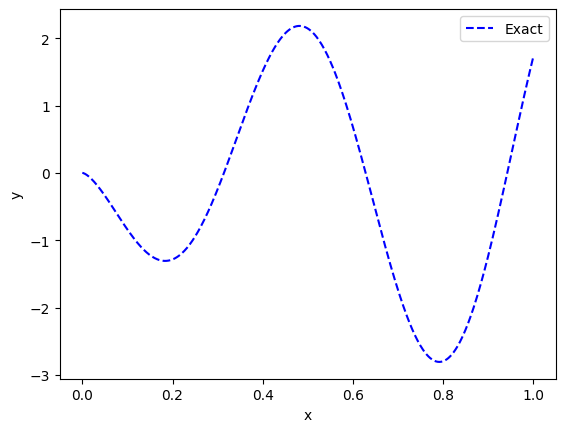

In [4]:
x_plot = np.linspace(0, 1, 500)[:, None]
y_plot = fun(x_plot)
plt.plot(x_plot, y_plot, 'b--', label='Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Add the design space, sampler and finally the training data.

In [5]:
parameter_DesignSpace: f3dasm.DesignSpace = f3dasm.make_nd_continuous_design(
    bounds=np.tile([0.0, 1.0], (dimensionality, 1)),
    dimensionality=dimensionality,
)

sampler = f3dasm.sampling.SobolSequence(design=parameter_DesignSpace)

train_data: f3dasm.Data = sampler.get_samples(numsamples=numsamples)
train_data.add_output(output=fun(train_data))

Let's see how the training data looks like.

In [6]:
train_data.data

,input,output
,x0,y
0,0.0000,-0.000000
1,0.5000,2.144220
2,0.7500,-2.568819
3,0.2500,-0.946268
4,0.3750,1.106824
5,0.8750,-1.847958
6,0.6250,0.082948
7,0.1250,-1.060997
8,0.1875,-1.306436


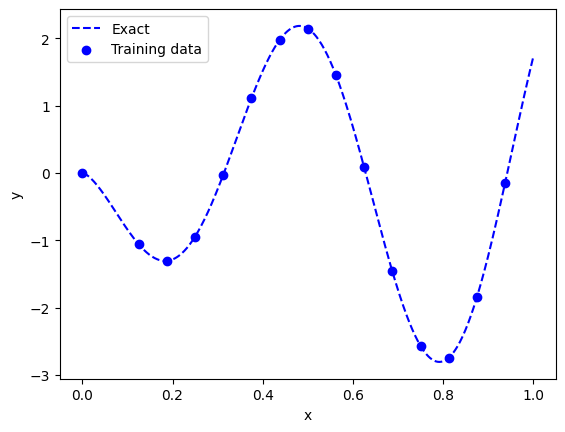

In [7]:
plt.plot(x_plot, y_plot, 'b--', label='Exact')
plt.scatter(train_data.data['input'], train_data.data['output'], c='b', label='Training data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 4. Regression and prediction

In [8]:
param = f3dasm.regression.gpr.Sogpr_Parameters(kernel=kernel)

regressor = f3dasm.regression.gpr.Sogpr(
    train_data=train_data, 
    design=train_data.design,
    parameter=param,
)

surrogate = regressor.train()

Let's evaluate the mean and the variance of the Gaussian process posterior.

In [9]:
x_plot_data = f3dasm.Data(design=train_data.design)
x_plot_data.add_numpy_arrays(input=x_plot, output=x_plot)
mean, var = surrogate.predict(test_input_data=x_plot_data)

ucb, lcb = [mean + 2 * (-1) ** k * np.sqrt(np.abs(var)) for k in range(2)]

Let's see how the prediction looks like.

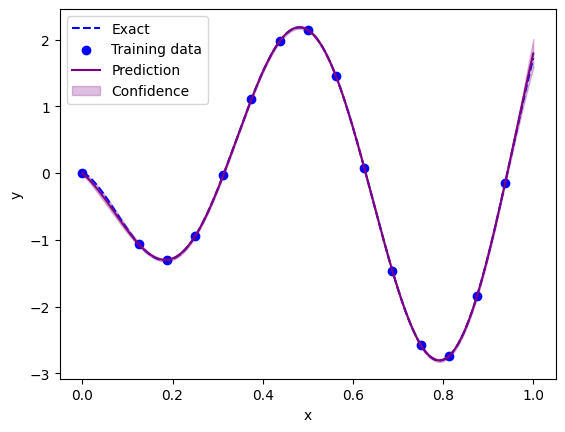

In [10]:
plt.plot(x_plot, y_plot, 'b--', label='Exact')
plt.scatter(train_data.data['input'], train_data.data['output'], c='b', label='Training data')
plt.plot(x_plot, mean, color='purple', label='Prediction')
plt.fill_between(x_plot.flatten(), lcb.flatten(), ucb.flatten(), color='purple', alpha=.25, label='Confidence')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## 5. Exercises
1. Change the cosine GP kernel into an RBF kernel (`gpytorch.kernels.RBFKernel()`). What do you notice?
2. Change the function to regress from the AlpineN2 into the Schwefel function (`f3dasm.functions.Schwefel`). What do you notice?
3. Change the number of data points from `15` into a higher number $\le$`150`. Does the GP regress well?